# Yahoo Finance Dataset Analysis

We decided to download the datasets from the yahoo finance [site](https://finance.yahoo.com/), each of which has 7 **features**: *date*, *open*, *high*, *low*, *close*, *adj close*, *volume*.

Each of the dataset was selected by taking the maximum range of date available.

The dataset analyzed are:
- Apple: *43 years* range, **10k rows**
- Coca-Cola: *61 years* range, **15k rows**,
- Volkswagen Auto: *25 years* range, **6k rows**
- Lockheed Martin Corporation: *46 years* range, **11k rows**

In [ ]:
# !pip install dtw-python

In [1]:
# Here we have useful import
from sklearn.preprocessing import StandardScaler
from dtw import *

import pandas as pd
import numpy as np

import datetime as dt


import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.style.use('seaborn')
# plt.rc("figure", figsize=(10,10))  # size of the figure
# to quickly get access to a list of the tickers in different indices

#  To Use online Yahoo Finance API
import warnings
from pandas_datareader import data as pdr
# to override deprecations in pandas-datareader
import yfinance as yf
# To set up the start/end dates for the prices
import datetime as dt
# to quickly get access to a list of the tickers in different indices
from yahoo_fin import stock_info as si
# Settings
pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")
yf.pdr_override()

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## Set constant variable

In [2]:
DIR_DATA = "../dataset/yahoo_finance_dataset/"

# Tickers for CSV files
TICKERS = ["AAPL", "KO", "VOW3.DE", "LMT"]

## Functions

In [3]:
# Load the datasets
def get_dataframe(ticker):
    FORMAT_FILE = "{}.csv"
    df = pd.read_csv(DIR_DATA + FORMAT_FILE.format(ticker))
    # fill eventual NaN values
    df = df.fillna(method = 'ffill').fillna(method = 'bfill')
    return df

### Use Yhaoo API

In [ ]:
def get_daterange(num_of_years=1):
    """Set the start and end date for the dataset.
    Args:
        num_of_years (int, optional): Number of years to consider. Defaults to 1.
    
    Returns:
        start (datetime.date): Start date.
        end (datetime.date): End date.
    """
    # Set up the start/end dates for the prices
    start = dt.date.today() - dt.timedelta(days = int(365.25*num_of_years))
    end = dt.date.today()
    return start, end


def get_tickers(index="dow"):
    """Get the list of tickers from a list of indices.

    Args:
        index (str, optional): Index name,defaults to "dow".

    Returns:
        tickers (List[str]): List of tickers.
    """
    # Get the list of tickers in the Dow Jones index (others: tickers_dow, 
    # tickers_ftse100, tickers_ftse250, tickers_ibovespa, tickers_nasdaq, 
    # tickers_nifty50, tickers_niftybank, tickers_other, tickers_sp500)
    if index == "dow":
        tickers = si.tickers_dow()
    elif index == "nasdaq":
        tickers = si.tickers_nasdaq()
    elif index == "sp500":
        tickers = si.tickers_sp500()
    elif index == "ibovespa":
        tickers = si.tickers_ibovespa()
    elif index == "ftse100":
        tickers = si.tickers_ftse100()
    elif index == "ftse250":
        tickers = si.tickers_ftse250()
    elif index == "nifty50":
        tickers = si.tickers_nifty50()
    elif index == "niftybank":
        tickers = si.tickers_niftybank()
    elif index == "other":
        tickers = si.tickers_other()
    else:
        raise ValueError("Index not found")
    return tickers


def get_dataframe_lib(tickers, start, end):
    """Generate dataset from yahoo finance, starting from `start` to `end` date,
    for the list of `tickers`.

    Args:
        tickers (_type_): List of tickers, i.e. assets.
        start (_type_): Start date.
        end (_type_): End date.

    Returns:
        dataset (pd,Dataframe): dataset with the prices of the assets.
    """
    # df = si.get_data(ticker)
    dataset = pdr.get_data_yahoo(tickers, start, end)
    return dataset


In [ ]:
# Get the date range for 10 years
start, end = get_daterange(num_of_years=10)

# Get the list of tickers in the Dow Jones index
tickers = get_tickers(index="dow")
df = get_dataframe
df = get_dataframe_lib(tickers, start, end)
df.head()

### Compute Returns

In [ ]:
# Create a new column for each ticker to store the returns
def get_returns(df):
    """Compute the returns of the assets in the dataset.

    Args:
        df (_type_): dataset with the prices of the assets.
    """
    for ticker in df.columns.levels[1]:
        df["Log_Returns", ticker] = np.log(df["Adj Close", ticker] / df["Adj Close", ticker].shift(1))
    
    # Drop the NaN values
    df = df.dropna()
    return df


In [ ]:
dataset = df.copy()
dataset = get_returns(dataset)

dataset["Log_Returns"].head()

### Create a datset for one Asset

In [ ]:
def get_ticker_df(dataset, ticker="AAPL"):
    """Get the dataframe for a specific ticker.

    Args:
        ticker (str, optional): Ticker name. Defaults to "AAPL".

    Returns:
        df (pd.DataFrame): Dataframe with the prices of the asset.
    """
    
    columns = dataset.columns.levels[0]
    df = dataset[columns[0], ticker]
    for column in columns[1:]:
        temp = dataset[column, ticker]
        df = pd.concat([df, temp], axis=1) 
    df = df.droplevel(1, axis=1)
    return df 

In [ ]:
one_ticker_df = dataset.copy()

one_ticker_df = get_ticker_df(one_ticker_df, "GOOG")
one_ticker_df.head()

### Volatility

Sources:
- [Calculate the Volatility of Historic Stock Prices with Pandas and Python](https://www.learnpythonwithrune.org/calculate-the-volatility-of-historic-stock-prices-with-pandas-and-python/)
- [Volatility](https://corporatefinanceinstitute.com/resources/capital-markets/volatility-vol/)

Volatility is a measure of the rate of fluctuations in the price of a security over time. It indicates the level of risk associated with the price changes of a security. Investors and traders calculate the volatility of a security to assess past variations in the prices to predict their future movements.

We create a new column called 'Log returns' with the daily log return of the Close price.
We use log returns instead of daily simple return, since the log returns have the advantage that you can add them together, while this is not the case for simple returns. Therefore the log returns are used in most financial analysis.

We need **standard deviation** for the volatility of the stock that is computed in this way:

$\sigma_p = \sigma_d * \sqrt{p}$

$\sigma_a = \sigma_d * \sqrt{252}$

**NOTE:**
- $\sigma_d$ : means the *daily deviation*
- $\sigma_a$ : means the *annualy deviation*
- 252 trading days per year

The volatility is defined as the annualized standard deviation

In [4]:
def compute_volatility(ticker, df):
     # Compute the daily log return
    df['Log_Returns'] = np.log(df['Close']/df['Close'].shift())  # create new column 'Log_returns'
    # Compute standard deviation
    df['Log_Returns'].std()
    # Fill the missing values
    df['Log_Returns'] = df['Log_Returns'].fillna(method="bfill")
    # Compute volatility
    volatility = df['Log_Returns'].std()*252**.5 # we have 252 trading days per year
    # Plot volatility
    str_vol = str(round(volatility, 4)*100)

    fig, ax = plt.subplots()
    df['Log_Returns'].hist(ax=ax, bins=50, alpha=0.6, color='b')
    ax.set_xlabel("Log Return")
    ax.set_ylabel("Freq of log return")
    ax.set_title(ticker + " volatility: " + str_vol + "%")

### DTW

In [5]:
# DTW
def compute_dtw(data, col1="Volume", col2="Log_Returns", normalize=True):
    x = data[col1]
    y = data[col2]

    if normalize:
        scaler = StandardScaler()
        reshape = x.values.reshape(-1, 1)
        x = scaler.fit_transform(reshape)
        reshape = y.values.reshape(-1, 1)
        y = scaler.fit_transform(reshape)
    else:
        # We compute Pearson Correlation Coefficient if and only if
        # our data are not normalized, otherwise it doesn't work
        pcc = np.corrcoef(x, y)
        print("Pearson Correlation Coefficient: ", pcc[0,1])

    # DTW Parameters: see https://dynamictimewarping.github.io/py-api/html/api/dtw.dtw.html#dtw.dtw
    
    plt.rc("figure", figsize=(10,10))  # size of the figure
    dtw(x, y, keep_internals=True).plot(type="threeway", xlab=col1, ylab=col2)

    plt.rc("figure", figsize=(10,10))  # size of the figure
    dtw(x, y, keep_internals=True, 
        step_pattern=rabinerJuangStepPattern(ptype=4, slope_weighting="d"))\
        .plot(type="twoway", offset=-9).legend((col1, col2), loc="upper left")

### Main Function

In [6]:
def see_ticker_stat(ticker):
    # Retrieve the dataframes
    df = get_dataframe(ticker)
    
    # Compute volatility
    compute_volatility(ticker, df)
    # Compute DTW
    compute_dtw(df, "Volume", "Log_Returns", normalize=True)

#### Coca Cola

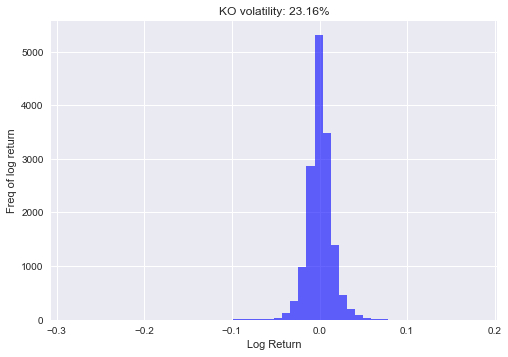

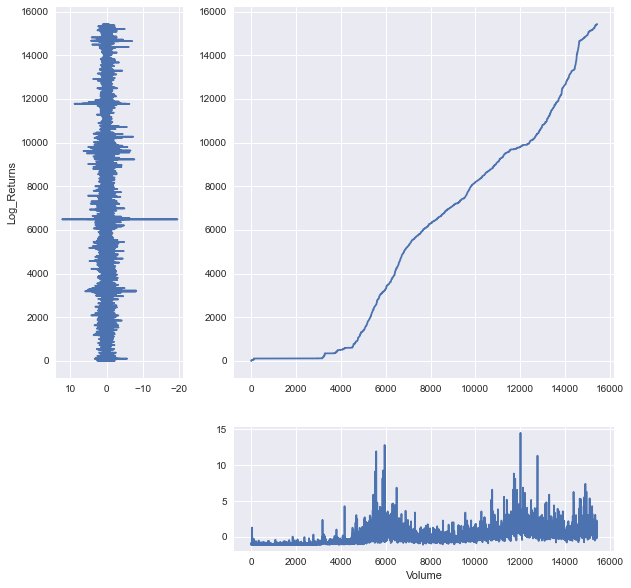

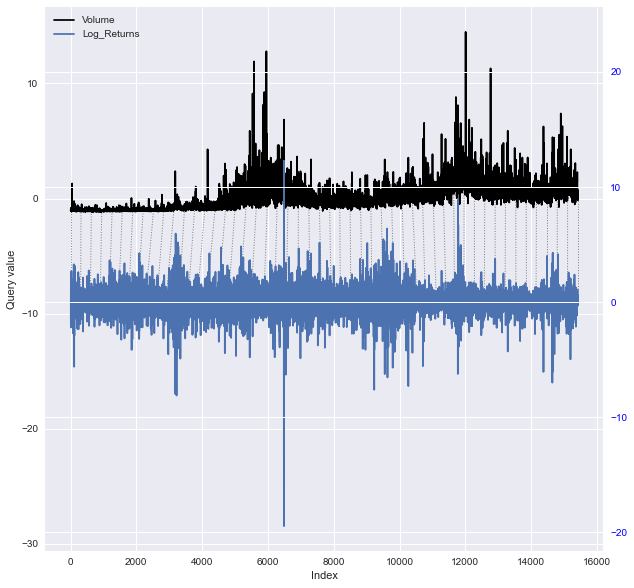

In [7]:
# COCA_COLA
see_ticker_stat(TICKERS[1])

#### Volkswagen

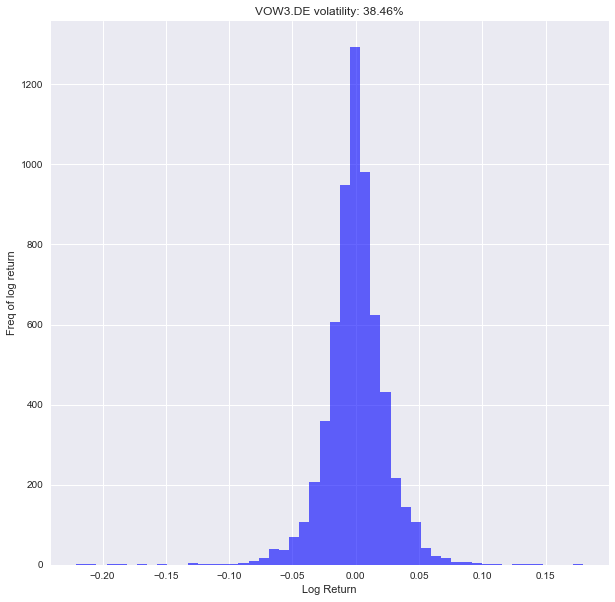

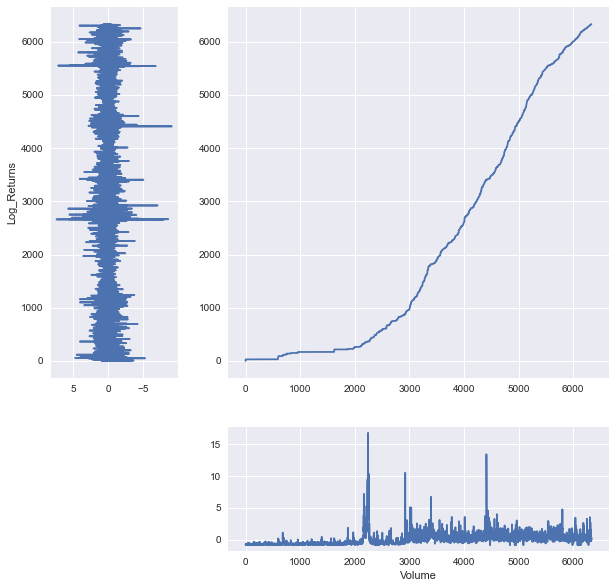

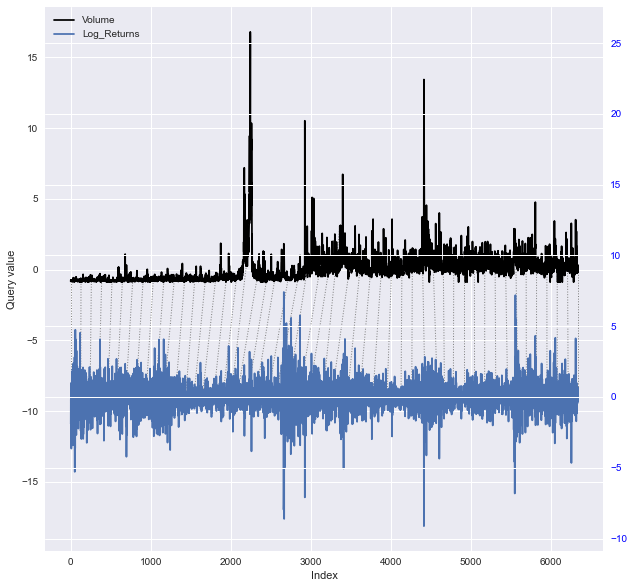

In [8]:
# VOLKSWAGEN
see_ticker_stat(TICKERS[2])

#### LMT

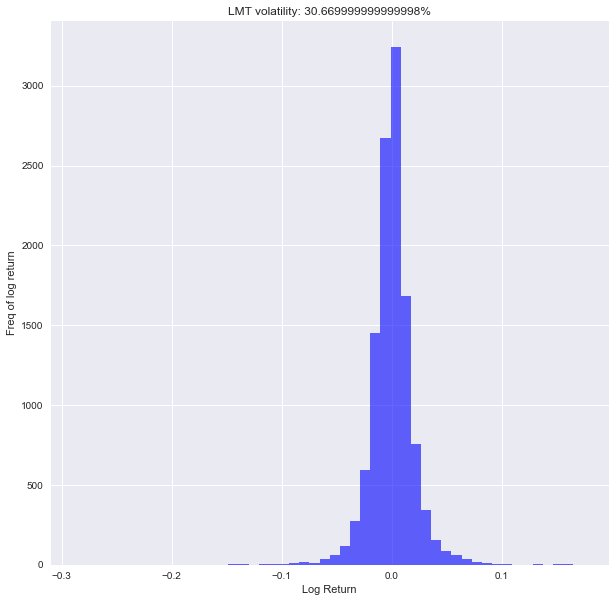

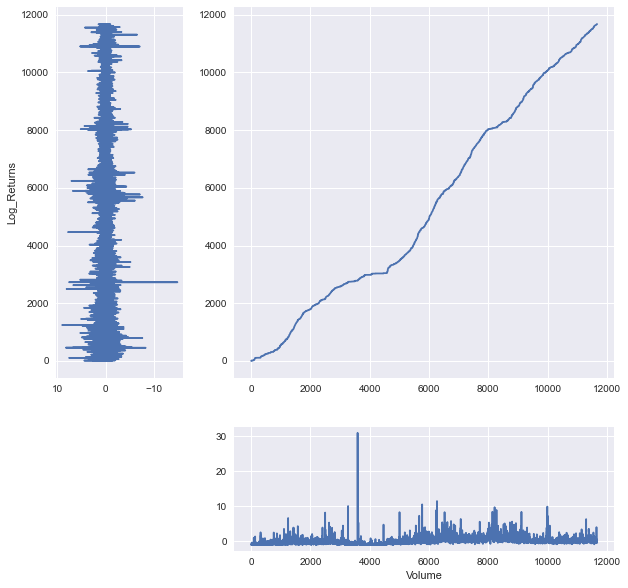

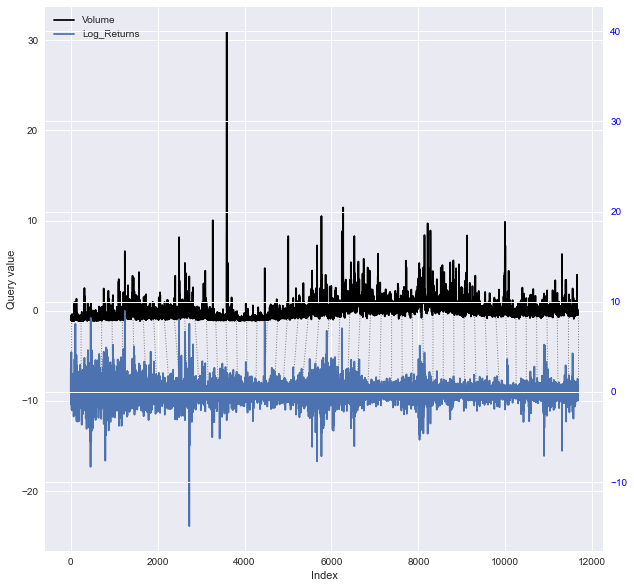

In [9]:
# LMT
see_ticker_stat(TICKERS[3])

## Online Dataset

In [ ]:
def compute_online_df(years, index):
    # YAHOOFINANCE API
    # Get the date range for 10 years
    start, end = get_daterange(num_of_years=years)
    # Get the list of tickers in the Dow Jones index.
    tickers = get_tickers(index=index)
    # Get the dataset
    df = get_dataframe_lib(tickers, start, end)
    # Compute returns
    df = get_returns(df)
    
    return df, tickers

In [ ]:
dataset, tickers = compute_online_df(10, "dow")

# There are at least 30 tickers, and the computation is quite long, so we 
# choose only the first three
for ticker in tickers[:2]:
    # Create a new dataframe for each ticker
    df = get_ticker_df(dataset, ticker)
    
    print("#"*100)
    print("#        Ticker: ", ticker)
    print("#"*100)
    
    # Compute volatility
    compute_volatility(df)
    # Compute DTW
    compute_dtw(df, "Volume", "Log_Returns", normalize=True)
    
